In [119]:
%matplotlib inline
import os
import re

import pandas as pd
import numpy as np
import gensim

import multiprocessing

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Input
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping  

from keras.models import Model
from keras.utils import to_categorical

from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec

# Классы (методы)

In [120]:
class Preprocessing(object):
    
    def preproc_df(df, text_field, digits = False):
        """
        Предобработка текста, предназначения для DataFrame.
        
        Параметры:
        ***************************************************
        df - DataFrame.
        text_field - название столбца, в котором требуется предобработка текста.
        digits - оставить числа (по умолчанию False).
        ***************************************************
        Возвращает: Обработанный DataFrame.
        ***************************************************
        """
        df[text_field] = df[text_field].str.replace(r"<.*?>", "")
        if digits:
            df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9']", " ") 
        else:
            df[text_field] = df[text_field].str.replace(r"[^A-Za-z']", " ")
        df[text_field] = df[text_field].str.replace('  ', ' ')
        df[text_field] = df[text_field].str.lower()
        return df

    
    def preproc_list(text, digits = False):
        """
        Предобработка текста. 
        
        Параметры:
        ***********************************************
        text - текст.
        digits - оставить числа (по умолчанию False).
        ***********************************************
        Возвращает: обработанный текст.
        ***********************************************
        """
        text = re.sub(r"<.*?>", ' ', text)
        if digits:
            text = re.sub(r"[^A-Za-z0-9']", " ", text)
        else:
            text = re.sub(r"[^A-Za-z']", " ", text)
        text = re.sub('  ', ' ', text)
        text = text.lower()
        return text.strip()

In [231]:
class Vectorizer(object):
    
    def cv(data):
        """
        Матрица вхождений.
        
        Параметры:
        ***********************************************
        data - Данные.
        ***********************************************
        Возвращает:  
        matrix - матрица вхождений (документ*словарь)
        count_vectorizer - объект.
        ***********************************************
        """   
        cv_vectorizer = CountVectorizer()
        matrix = cv_vectorizer.fit_transform(data)
        return matrix, cv_vectorizer


    def tf_idf(data): 
        """
        Переводит матрицу в матрицу - документ*словарь(tf-idf)
        
        Параметры:
        ***********************************************
        data - данные в текстовом виде.
        ***********************************************
        Возвращает:
        train - матрица документ*словарь
        tf_idf_vectorizer - объект. 
        ***********************************************
        """       
        tf_idf_vectorizer = TfidfVectorizer() 
        matrix  = tf_idf_vectorizer.fit_transform(data)
        return matrix, tf_idf_vectorizer


    def get_important_features(vectorizer, model, n=5):
        """
        Позволяет получить важные признаки для каждого из 2 классов. 
        
        Параметры:
        ***********************************************
        vectorizer - объект.
        model - обученная модель.
        n - кол-во важных признаков.
        ************************************************
        Возвращает:
        positive_important - топ важных признаков для класса 1.
        negative_important - топ важных признаков для класса 0.
        ***********************************************
        """   
        index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
        word_importances = [(coef, index_to_word[index]) for index,coef in enumerate(model.coef_[0])]
        sorted_coeff = sorted(word_importances, key = lambda x: x[0], reverse=True)
        positive_important = sorted_coeff[:n]
        negative_important = sorted_coeff[-n:][::-1]
        return positive_important, negative_important

    def parameters_for_log(X_train, y_train, step, stop):
        
        """
        Позволяет получить важные признаки для каждого из 2 классов. 
        
        Параметры:
        ***********************************************
        X_train - тренеровочная выборка.
        y_train - метки классов.
        step - шаг для выбора параметра (регуляризация).
        stop - максимальный параметр.
        ************************************************
        Возвращает:
        positive_important - топ важных признаков для класса 1.
        negative_important - топ важных признаков для класса 0.
        ***********************************************
        """   
    
        #Код для подбора C и регуляризации L1 и L2, Проверяется на кросс-валидации.
        grid = {'C' : np.arange(0.5,stop,step), 'penalty' : ['l2','l1']}
        cv = KFold(n_splits=5, shuffle=True, random_state=241)
        model = LogisticRegression(class_weight='balanced', n_jobs=1, random_state=999)
        gs = GridSearchCV(model, grid, scoring='accuracy', cv=cv, verbose=1)
        gs.fit(X_train, y_train)

        for a in gs.grid_scores_:
            print(a.parameters)
            print(a.mean_validation_score)
            print('\n')
    
    

In [244]:
class Extra (object):
    
    def plot_LSA(data, labels, s = 8, size_leg = 20):
        """
        # Проецирует признаки на двумерную плоскость с помощью SVD и задает scatterplot.
        
        Параметры:
        ***************************************************
        data - данные.
        labels - метки
        s - размер точек.
        size_leg - размер легенды (по умолчанию 20).
        ***************************************************
        Возвращает: ничего.
        ***************************************************
        """
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(data)
        lsa_scores = lsa.transform(data)
        colors = ['red','blue']
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=s, alpha=1, c=labels, cmap=matplotlib.colors.ListedColormap(colors))
            
        red_patch = mpatches.Patch(color='red', label='Negative')
        blue_patch = mpatches.Patch(color='blue', label='Positive')
        plt.legend(handles=[red_patch, blue_patch], prop={'size': size_leg}, loc = 'upper right')
        
        
    def cm_matrix (y_test, y_predict, cm_print = False ):
        """
        # Выводит матрицу ошибок (графический и текстовый вид).
        
        Параметры:
        ***************************************************
        y_test - тестовые данные.
        y_predict - метки
        cm_print - размер точек.
        ***************************************************
        Возвращает: ничего.
        ***************************************************
        """
        conf_matrix = confusion_matrix(y_test, y_predict)
        if cm_print:
            tn, fp, fn, tp = conf_matrix.ravel()
            print('TN:{0}  FP:{1}'.format(tn,fp))
            print('FN:{0}  TP:{1}'.format(fn,tp))
            print('   predictor')
        sns.heatmap(conf_matrix, linewidths=0, annot = True, fmt = 'd', cbar=True)

# Загружаем данные

In [123]:
# Получаем список 
directory = 'D:/DATASET/IMDB_NLP/train/pos/' 
files = os.listdir(directory)

positive_comment = []
for file in files:
    with open('D:/DATASET/IMDB_NLP/train/pos/{}'.format(file),'r',encoding='utf-8') as f:
        positive_comment.append(f.read())

In [124]:
# Получаем список 
directory = 'D:/DATASET/IMDB_NLP/train/neg/' 
files = os.listdir(directory)

negative_comment = []
for file in files:
    with open('D:/DATASET/IMDB_NLP/train/neg/{}'.format(file),'r',encoding='utf-8') as f:
        negative_comment.append(f.read())

# Объединение данных.

In [125]:
# Добавляем метки и объединяем.
lp = [1 for i in np.arange(len(positive_comment))]
ln = [0 for i in np.arange(len(negative_comment))]

neg_text_score = list(zip(negative_comment, ln))
pos_text_score = list(zip(positive_comment, lp))
np_text_score = pos_text_score + neg_text_score

In [126]:
# Делаем DataFrame table
data = pd.DataFrame(np_text_score, columns=['TEXT','LABEL'])

# Размешать строки (frac = 1 - все строки размешать, drop = True - удалить старые)
data = data.sample(frac=1).reset_index(drop=True)

In [127]:
data.info(verbose=True, null_counts=True, max_cols= True, memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
TEXT     25000 non-null object
LABEL    25000 non-null int64
dtypes: int64(1), object(1)
memory usage: 390.7+ KB


# Препроцессинг DF

In [128]:
# Процесс предобработки данных.
data = Preprocessing.preproc_df(data,'TEXT', digits=True)

In [129]:
# Проверим данные после предобработки
data.loc[23500, 'TEXT']

" iowa wants to be requiem for a dream for midwest meth but it comes across as a hard r rated reefer madness  yes drugs are bad and meth is horribly pernicious as an addiction and how it destroys people families and communities but these characters who are either dumb or ridiculous and the eye rolling plot won't teach that lesson to anyone while writer director star matt farnsworth has some charisma on screen his partner diane foster plays a wincibly silly wide eyed innocent corrupted by drugsas was already satirized by susan sarandon in the rocky horror picture show  i really felt sorry for her for all the totally unnecessary nudity she was put through it wasn't until the end of the film that i realized i was supposed to think these two were recent high school graduates to explain some of their naivet  as we are bombarded by their school photos but if so they even looked older than the folks on the o c  while they have good chemistry on screen they are a pale imitation of a badlands t

In [130]:
# Проверяем на соотношение данных.
data.groupby('LABEL').count()

,TEXT
LABEL,
0,12500
1,12500


#  Токенезация текста

In [131]:
# Токенезируем наш текст.
token_words = RegexpTokenizer(r'\w+')

data['TOKENS'] = data['TEXT'].apply(token_words.tokenize)
data.head()

,TEXT,LABEL,TOKENS
0,the late 80's saw an inexplicable rash of supe...,0,"[the, late, 80, s, saw, an, inexplicable, rash..."
1,some genre films need to be dressed up this on...,1,"[some, genre, films, need, to, be, dressed, up..."
2,there is a scene in dan in real life where the...,1,"[there, is, a, scene, in, dan, in, real, life,..."
3,the cat's meow contains a few scenes that boa...,0,"[the, cat, s, meow, contains, a, few, scenes, ..."
4,oh dear we don't like it when our super hero l...,1,"[oh, dear, we, don, t, like, it, when, our, su..."


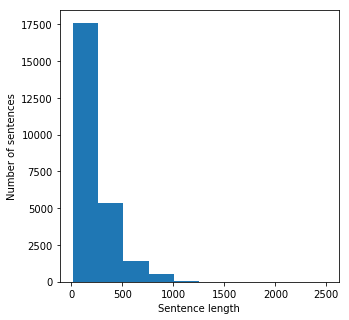

In [132]:
# Распределение кол-ва слов в предложении.
len_text = [len(sentence) for sentence in data['TOKENS']]
fig = plt.figure(figsize=(5, 5)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(len_text)
plt.show()

In [133]:
print('Длина самого большого предложения:', max(len_text))
print('Длина самого маленкього предложения:', min(len_text))

Длина самого большого предложения: 2498
Длина самого маленкього предложения: 10


# Bag of Words

In [134]:
# Векторизуем, как матрица вхождений
X = data['TEXT'].tolist()
y = data['LABEL'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=999)

X_train_bow, count_vectorizer = Vectorizer.cv(X_train)
X_test_bow = count_vectorizer.transform(X_test)

In [135]:
print('Bag of words train:', X_train_bow.shape)
print('Bag of words test:', X_test_bow.shape)

Bag of words train: (20000, 69071)
Bag of words test: (5000, 69071)


# Метод для рисования признаков (SVD)

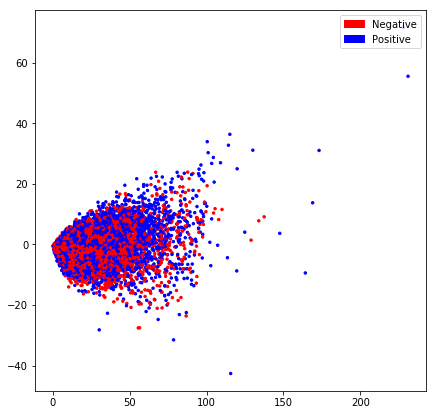

In [240]:
# Метод, который проецирует признаки на двумерную плоскость с помощью SVD.
fig = plt.figure(figsize=(7, 7))          
Extra.plot_LSA(X_train_bow, y_train, s = 6, size_leg = 10)
plt.show()

# Подбор параметров на кросс-валидации

In [137]:
%%time
Vectorizer.parameters_for_log(X_train_bow, y_train, step=5, stop=20)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.7min finished


{'C': 0.5, 'penalty': 'l2'}
0.87775


{'C': 0.5, 'penalty': 'l1'}
0.87165


{'C': 5.5, 'penalty': 'l2'}
0.8697


{'C': 5.5, 'penalty': 'l1'}
0.85825


{'C': 10.5, 'penalty': 'l2'}
0.8682


{'C': 10.5, 'penalty': 'l1'}
0.8567


{'C': 15.5, 'penalty': 'l2'}
0.86755


{'C': 15.5, 'penalty': 'l1'}
0.85565


Wall time: 2min 45s


D:\AnacondaP2\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


# Модель логистической регрессии

In [138]:
%%time
# Строим модель - логистическую регрессию.
model = LogisticRegression(C = 0.5, penalty='l2', class_weight='balanced', solver = 'newton-cg', n_jobs=1, random_state=999)
model.fit(X_train_bow, y_train)

y_predict = model.predict(X_test_bow)

Wall time: 8.79 s


# Оценка модели

In [139]:
# Определим функцию для оценки модели
print('accuracy: {0}\n'.format(accuracy_score(y_test, y_predict)))
print(classification_report(y_test, y_predict, digits=3))

accuracy: 0.887

             precision    recall  f1-score   support

          0      0.892     0.876     0.884      2454
          1      0.883     0.897     0.890      2546

avg / total      0.887     0.887     0.887      5000



TN:2150  FP:304
FN:261  TP:2285
   predictor


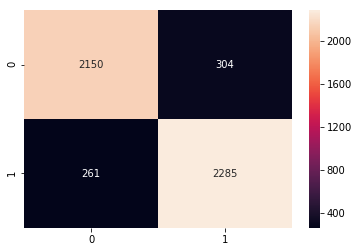

In [245]:
# Матрица ошибок.
Extra.cm_matrix(y_test=y_test, y_predict=y_predict, cm_print=True)

# Главные признаки по верси bow для logistic regression

In [141]:
pos_feature, neg_feature = Vectorizer.get_important_features(count_vectorizer, model, n = 10)

In [142]:
neg_feature

[(-1.8632512509248982, 'worst'),
 (-1.8468159023214201, 'waste'),
 (-1.6260537993775586, 'disappointment'),
 (-1.566126640741882, 'awful'),
 (-1.4728022536085195, 'boring'),
 (-1.4541883555352342, 'poorly'),
 (-1.3265611788356748, 'lacks'),
 (-1.2978364773320699, 'mess'),
 (-1.1923060051805419, 'horrible'),
 (-1.1483152365065217, 'alright')]

In [143]:
pos_feature

[(1.193628516202395, 'refreshing'),
 (1.1899047090926065, 'excellent'),
 (1.1022365385478405, 'funniest'),
 (1.0869462271581336, 'perfect'),
 (1.0857692519871318, 'rare'),
 (1.0848626508231753, 'superb'),
 (1.0551566315587997, 'surprisingly'),
 (0.9986353475085676, 'wonderfully'),
 (0.954331968038489, 'flight'),
 (0.94418046045325, 'wonderful')]

# TF-IDF

In [144]:
# Преобразовываем тренеровочную выборку и тестовую в TF-IDF
X_train_ti, ti_vectorizer = Vectorizer.tf_idf(X_train)
X_test_ti = ti_vectorizer.transform(X_test)

In [145]:
X_train_ti.shape

(20000, 69071)

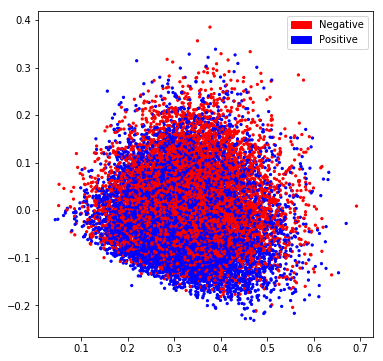

In [242]:
# График разбросонности для TF-IDF
fig = plt.figure(figsize=(6, 6)) 
Extra.plot_LSA(X_train_ti, y_train, s=5, size_leg=10)
plt.show()

# Логистическая регрессия.

In [147]:
Vectorizer.parameters_for_log(X_train_ti, y_train,step=5, stop=20)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   44.3s finished


{'C': 0.5, 'penalty': 'l2'}
0.8734


{'C': 0.5, 'penalty': 'l1'}
0.84895


{'C': 5.5, 'penalty': 'l2'}
0.8891


{'C': 5.5, 'penalty': 'l1'}
0.87705


{'C': 10.5, 'penalty': 'l2'}
0.8886


{'C': 10.5, 'penalty': 'l1'}
0.8725


{'C': 15.5, 'penalty': 'l2'}
0.8882


{'C': 15.5, 'penalty': 'l1'}
0.8699




D:\AnacondaP2\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [148]:
%%time
# Строим модель для TF-IDF - логистическую регрессию.
model_ti = LogisticRegression(C =5, penalty='l2', class_weight='balanced', 
                              solver = 'newton-cg', n_jobs=1, random_state=999)
model_ti.fit(X_train_ti, y_train)

y_predict_ti = model.predict(X_test_ti)

Wall time: 2.46 s


In [149]:
# Оценка модели.
print('accuracy: {0}\n'.format(accuracy_score(y_test, y_predict_ti)))
print(classification_report(y_test, y_predict_ti, digits=3))

accuracy: 0.8712

             precision    recall  f1-score   support

          0      0.917     0.811     0.861      2454
          1      0.836     0.929     0.880      2546

avg / total      0.876     0.871     0.871      5000



TN:1990  FP:464
FN:180  TP:2366
   predictor


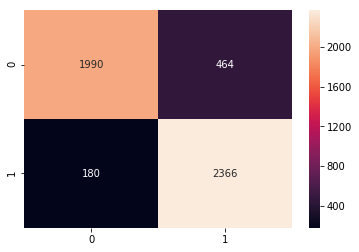

In [246]:
Extra.cm_matrix(y_test, y_predict_ti, cm_print=True)

# Главные признаки по версии TF-IDF

In [151]:
# Получаем главные признаки tf-idf.
pos_feature_ti, neg_feature_ti = Vectorizer.get_important_features(ti_vectorizer, model_ti, 10)

In [152]:
neg_feature_ti

[(-13.792804724875976, 'worst'),
 (-10.568452225063373, 'awful'),
 (-9.944917536730626, 'waste'),
 (-9.609362400548045, 'boring'),
 (-8.784188627852782, 'bad'),
 (-7.775576137015211, 'poor'),
 (-7.397943402862398, 'worse'),
 (-7.17742878792259, 'nothing'),
 (-7.094643802117312, 'unfortunately'),
 (-7.061444549085093, 'disappointment')]

In [153]:
pos_feature_ti

[(9.546536747812292, 'excellent'),
 (9.480856874587241, 'great'),
 (7.627576149003102, 'perfect'),
 (7.0844498550525214, 'wonderful'),
 (7.0562481600058975, 'best'),
 (5.935188911836304, 'favorite'),
 (5.871492771717381, 'amazing'),
 (5.771815512901667, 'superb'),
 (5.729453527724319, 'today'),
 (5.587480752292499, 'loved')]

# CNN for NLP

In [197]:
# Формируем данные для word2vec
w2v_input_data = [Preprocessing.preproc_list(text) for text in positive_comment+negative_comment]
labels = lp+ln

# Разбиваем данные на тренеровочную и тестовую.
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(w2v_input_data, labels, test_size=0.2, random_state=999)

# Записываем набор слов в файл. 
with open('DATA.txt', 'w', encoding='utf-8') as f:
    f.writelines(w2v_input_data)

In [198]:
# Высота матрицы (максимальное количество слов)
TEXT_LENGTH = 1500

# Размер словаря
NUM = 80000

def get_sequences(tokenizer, x):
    sequences = tokenizer.texts_to_sequences(x)
    return pad_sequences(sequences, maxlen=TEXT_LENGTH)

#Cоздаем и обучаем токенизатор
tokenizer = Tokenizer(num_words=NUM)
tokenizer.fit_on_texts(X_train_w2v)

# Отображаем каждый текст в массив идентификаторов токенов.
x_train_seq = get_sequences(tokenizer, X_train_w2v)
x_test_seq = get_sequences(tokenizer, X_test_w2v)

In [199]:
# Переводим числа в категориальные
y_train_w2v = to_categorical(y_train_w2v)
# Переводим числа в категориальные
y_test_w2v = to_categorical(y_test_w2v)

In [200]:
# Загружаем данные.
data_wrod2vec = gensim.models.word2vec.LineSentence('DATA.txt')

# Обучаем модель (размерность вектора 200)
model_w2v = Word2Vec(data_wrod2vec, size=200, window=5, min_count=3, workers=multiprocessing.cpu_count())

In [201]:
# Топ слов, которые близки по смыслу.
model_w2v.wv.most_similar(positive='love', topn=10)

[('hate', 0.6354060769081116),
 ('loved', 0.577600359916687),
 ('asleep', 0.5584490299224854),
 ('enjoy', 0.5270042419433594),
 ('adore', 0.4998621344566345),
 ('recommend', 0.4784364104270935),
 ('dislike', 0.4745352268218994),
 ('liked', 0.4710982143878937),
 ('pray', 0.4468879699707031),
 ('agree', 0.44642388820648193)]

In [202]:
print(len(model_w2v.wv.vocab))

41016


In [203]:
print(len(tokenizer.word_index.items()))

77787


In [206]:
# В нашем случае 200.
DIM = model_w2v.vector_size

# Матрица: словарь*размер пространства.
embedding_matrix = np.zeros((NUM, DIM))

# Добавляем часто встречающиеся слова в embedding слой
for word, i in tokenizer.word_index.items():
    if i >= NUM:
        break
    if word in model_w2v.wv.vocab.keys():
        embedding_matrix[i] = model_w2v.wv[word]

# Размер входа 1500
text_input = Input(shape=(TEXT_LENGTH,), dtype='int32')

# Размер embedding слоя.
text_encoder = Embedding(NUM, DIM, input_length=TEXT_LENGTH, weights=[embedding_matrix], trainable=False)(text_input)

x = Dropout(0.2)(text_encoder)

basket = []
for size, filters in [(2, 3), (3, 3), (4, 3), (5, 3)]:
    for i in range(filters):
        
        # Добавляем слой свертки.
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        
        # Добавляем слой пулинга.
        branch = GlobalMaxPooling1D()(branch)
        basket.append(branch)

# Сцепляем карты признаков.
x = concatenate(basket, axis=1)

# Добавляем dropout-регуляризацию
x = Dropout(0.2)(x)
x = Dense(30, activation='relu')(x)

x = Dense(2)(x) 
output = Activation('softmax')(x)

model_cnn = Model(inputs=[text_input], outputs=[output])
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 1500)         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1500, 200)    16000000    input_10[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 1500, 200)    0           embedding_10[0][0]               
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 1499, 1)      401         dropout_7[0][0]                  
__________________________________________________________________________________________________
conv1d_68 

In [207]:
early_stopping=EarlyStopping(monitor='val_loss')
history = model_cnn.fit(x_train_seq, y_train_w2v, batch_size=32, epochs=10, validation_split=0.25, callbacks=[early_stopping], verbose=1)

Train on 15000 samples, validate on 5000 samples
Epoch 1/10
15000/15000 [==============================] - 775s 52ms/step - loss: 0.7258 - acc: 0.5719 - val_loss: 0.6209 - val_acc: 0.6664
Epoch 2/10
15000/15000 [==============================] - 749s 50ms/step - loss: 0.6098 - acc: 0.6667 - val_loss: 0.5469 - val_acc: 0.7352
Epoch 3/10
15000/15000 [==============================] - 747s 50ms/step - loss: 0.5396 - acc: 0.7267 - val_loss: 0.4703 - val_acc: 0.7826
Epoch 4/10
15000/15000 [==============================] - 739s 49ms/step - loss: 0.4897 - acc: 0.7607 - val_loss: 0.4306 - val_acc: 0.8028
Epoch 5/10
15000/15000 [==============================] - 794s 53ms/step - loss: 0.4499 - acc: 0.7816 - val_loss: 0.4078 - val_acc: 0.8184
Epoch 6/10
15000/15000 [==============================] - 807s 54ms/step - loss: 0.4380 - acc: 0.7930 - val_loss: 0.4058 - val_acc: 0.8150
Epoch 7/10
15000/15000 [==============================] - 771s 51ms/step - loss: 0.4263 - acc: 0.8013 - val_loss: 0.4

In [215]:
predicted = np.round(model_cnn.predict(x_test_seq))
predicted[1]

array([0.5349902 , 0.46500978], dtype=float32)

In [226]:
# Оценка модели CNN.
score = model_cnn.evaluate(x_test_seq, y_test_w2v, verbose=1)
print('\n')
print('Test loss value:', score[0])
print('Test accuracy:', score[1])

5000/5000 [==============================] - 106s 21ms/step


Test loss value: 0.37265673112869263
Test accuracy: 0.835
